In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
import matplotlib.lines as ln
import matplotlib.cm as cm
import itertools
import random as rn
import seaborn as sns
import pandas as pd

In [2]:
def opentable(file,n): 
    '''
    Read file from Phylocell Matlab that is in a format of a table where the columns are:
    experiment    position    mother_cell/lineage   cell   t1    t2    ...    tn
    
    ti is a measurement (i.e. fluorescence in timepoint i)
    
    Convert table to dictionary
    '''
    dicfluo={}
    temp=np.zeros(n)
    with open(file, 'rb') as csvfile:
        fluofile = np.genfromtxt(csvfile, delimiter=',')
        for row in fluofile:
            exp=row[0]
            pos=row[1]
            lin=row[2]
            cell=row[3]
            fluorescence= row[4:n+4]
            dicfluo.setdefault(exp,{}).setdefault(pos, {}).setdefault(lin, {})[cell]=fluorescence
            
    return dicfluo

In [3]:
def tlinfluomean(time,dicPosMomDF):
    '''
    Function that returns the MEAN fluorescence of a LINEAGE the in a dictionary in a requested timepoint
    '''
    alllineages=[]
    for exp in dicPosMomDF.keys():
            for pos in dicPosMomDF[exp].keys():
                for lineage in dicPosMomDF[exp][pos].keys():
                    lineagefluo=[]
                    for cell in dicPosMomDF[exp][pos][lineage].keys():
                        fluotn=dicPosMomDF[exp][pos][lineage][cell][time]
                        lineagefluo.append(fluotn)
                    alllineages.append(np.mean(lineagefluo))
                    
    return alllineages
   

In [4]:
def slcv(dicWT,time):
    '''
    Sublineage Coefficient of Variation
    '''
    slcv=[]
    for a in range(0,time):
        #Get the fluorescence of each LINEAGE 
        alllineages=tlinfluomean(a,dicWT)
        #Calculate the mean fluorescence of the LINEAGES
        meanlineages=np.mean(alllineages)
        #Calculate SLCV 
        slcv.append(np.std([alllineages])/meanlineages)     
    return slcv   

In [5]:
def bootstrap(dicPosMomDF):
    '''
    Bootraping Sublineage Coefficient of Variation
    '''
    bootstrap=[]
    for a in range(0,50):
        alllineages=tlinfluomean(a,dicPosMomDF)
        bootWT=[rn.choice(alllineages) for _ in range(len(alllineages))]
        meanbootWT=np.mean(bootWT)
        bootstrap.append(np.std([bootWT])/meanbootWT)    
    return bootstrap

In [6]:
def errorbars(dicWT,time,bootsample):
    error_bar=[]
    for a in range(bootsample):
        error_bar.append(bootstrap(dicWT))
        
    bootmean=[np.mean([sample[a] for sample in error_bar]) for a in range(time)]
    bootstd=[np.std([sample[a] for sample in error_bar]) for a in range(time)]
    
    return [bootmean,bootstd]
    

In [7]:
time=50
dicWT=opentable('WT.csv',time)
dicE6=opentable('Mutant.csv',time)
#Set random seed
np.random.seed(100)
colors=["purple","blue"]
labels=['WT','mutant']

In [8]:
slcvWT=slcv(dicWT,time)
slcvE6=slcv(dicE6,time)
bootmeanWT,bootstdWT=errorbars(dicWT,time,100)
bootmeanE6,bootstdE6=errorbars(dicE6,time,100)

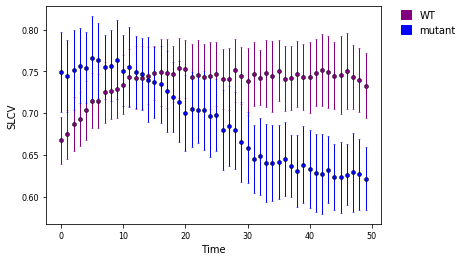

In [9]:
plt.errorbar(range(time),bootmeanWT,yerr=bootstdWT,mew=.5, fmt='o',lw=1,color=colors[0],ms=4,capsize=1,mec="k")
plt.errorbar(range(time),bootmeanE6,yerr=bootstdE6,mew=.5, fmt='o',lw=1,color=colors[1],ms=4,capsize=1,mec="k")

patch = ptc.Patch(color=colors[0], label=labels[0])
patch2 = ptc.Patch(color=colors[1], label=labels[1])
lgd=plt.legend(handles=[patch,patch2],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,handlelength=1, handleheight=1,frameon=False)


plt.ylabel('SLCV')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.xlabel('Time')

plt.savefig('SLCV.pdf',format='pdf', dpi=500,bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()